In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Activation
import keras.backend as K
from sklearn.model_selection import train_test_split
import scipy.stats as st
random_state = 42
%matplotlib inline

mcycle = pd.read_csv('mcycle.txt',delimiter='\t')

In [5]:
def f(x):
    """Polynomial function used to generate one-dimensional data"""
    return np.array(5 * x + 5 * x ** 4 - 9 * x ** 2)


In [6]:
def get_heteroscedastic_data(n_train: int = 1000, n_true: int = 200, sigma: float = 0.1):
    np.random.seed(42)
    X_train = np.linspace(0, 1, n_train)
    X_true = np.linspace(0, 1, n_true)
    y_train = f(X_train) + np.random.normal(0, sigma, n_train) * X_train
    y_true = f(X_true)

    return X_train, y_train, X_true, y_true

In [7]:
X, y, X_test, y_test = get_heteroscedastic_data()

In [8]:
X_train, X_cal, y_train, y_cal = train_test_split(X, y, test_size=0.2, random_state=42)

In [9]:
model = Sequential()
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=10, input_dim=1, activation='relu'))
model.add(Dense(units=1))
model.compile(loss='mean_squared_error', optimizer='adam')

In [11]:
model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=0)
y_pred = model.predict(X_cal)
model.evaluate(X_cal, y_cal)

7/7 [==============================] - 0s 665us/step - loss: 0.0035


0.0034640193916857243

In [18]:
def tilted_loss(q, y, f):
    e = (y - f)
    return K.mean(K.maximum(q * e, (q - 1) * e), axis=-1)

In [19]:
def mcycleModel():
    model = Sequential()
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(units=10, input_dim=1, activation='relu'))
    model.add(Dense(1))

    return model

In [20]:
qs = [0.2, 0.8]

# implement the conformal quantile regression using 0.1 and 0.9 quantiles as the intervals
initial_upper = []
initial_lower = []
models = []

for q in qs:
    model = mcycleModel()
    model.compile(loss=lambda y, f: tilted_loss(q, y, f), optimizer='adam')
    model.fit(X_train, y_train, epochs=1000, batch_size=16, verbose=0)
    models.append(model)
    if (q == qs[0]):
        initial_lower = model.predict(X_cal)
    else:
        initial_upper = model.predict(X_cal)

7/7 [==============================] - 0s 551us/step


In [10]:
import scipy.stats as st

In [21]:
# sort the calibration set and the predictions correspondingly for plotting
sorted_indices = np.argsort(X_cal, axis=0)
sorted_X_cal = X_cal[sorted_indices]
sorted_y_pred = y_pred[sorted_indices]

# similarly, sort initial_upper and initial_lower by using sorted_indices
initial_upper = np.array(initial_upper)
initial_lower = np.array(initial_lower)
sorted_upper = initial_upper[sorted_indices]
sorted_lower = initial_lower[sorted_indices]

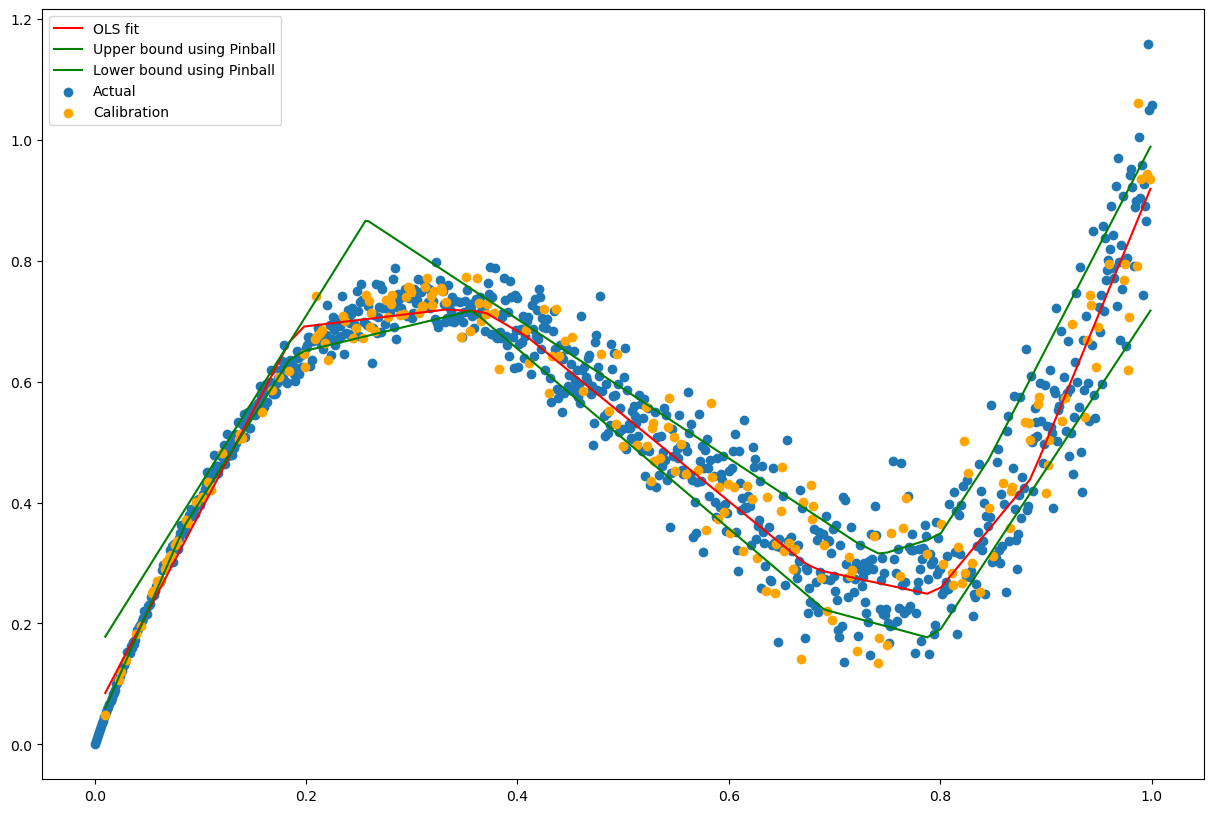

In [22]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_X_cal, sorted_y_pred, color='red', label='OLS fit')

plt.plot(sorted_X_cal, sorted_upper,
         color='green', label='Upper bound using Pinball')
plt.plot(sorted_X_cal, sorted_lower,
         color='green', label='Lower bound using Pinball')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()

In [24]:
sorted_y_cal = y_cal[sorted_indices]


In [25]:
# calculate the errors list by taking max(lower - y_cal, y_cal - upper) for each calibration point
errors = []
for i in sorted_indices:
    errors.append(max(sorted_lower[i] - sorted_y_cal[i], sorted_y_cal[i] - sorted_upper[i]))




In [26]:
errors = [i[0] for i in errors]

In [27]:
errors = np.array(errors)

In [28]:
errors

array([-6.45242333e-02, -2.11908221e-02,  1.26874447e-02, -2.14832425e-02,
       -1.36969090e-02, -4.06299829e-02, -2.74863243e-02,  8.44818354e-03,
        2.39912868e-02, -6.53675199e-02, -2.11190283e-02, -8.84526968e-03,
        4.61074114e-02, -3.13907266e-02, -4.79454398e-02, -5.52043319e-03,
       -5.30280471e-02, -5.15520573e-04, -5.58233261e-03, -3.28342915e-02,
        5.18375635e-03, -2.39219069e-02, -5.67762554e-02,  4.46357429e-02,
       -4.08682227e-03, -1.11126184e-01,  4.27305698e-03,  2.94172168e-02,
       -2.89300680e-02, -1.20457113e-02, -2.05074549e-02, -1.94556713e-02,
        4.30924296e-02, -2.38347054e-02, -4.72732186e-02, -1.85573101e-03,
       -4.23675776e-02, -1.04269981e-02, -1.41950250e-02, -6.16202354e-02,
       -7.92664289e-03,  5.12214601e-02,  2.48554349e-02,  5.22881746e-04,
       -6.76161647e-02, -2.00188160e-02, -5.85385561e-02,  9.43893194e-03,
       -4.31653261e-02, -2.27755904e-02,  6.85304403e-03, -6.91891909e-02,
       -2.85798311e-03, -

In [29]:
q_hat = np.quantile(errors, 0.59)

In [30]:
q_hat

-0.0067052014172077215

In [32]:
# calculate the true confidence intervals of 80 percent so that we can compare our prediction intervals with them
q95 = st.norm.ppf(0.60)
sigma = 1
y_test_sigma = q95 * sigma * X_test
true_upper = y_test + y_test_sigma
true_lower = y_test - y_test_sigma

# sort the training set and the predictions correspondingly for plotting
sorted_indices = np.argsort(X_test, axis=0)
sorted_X_test = X_test[sorted_indices]
sorted_y_test = y_test[sorted_indices]

# similarly, sort true_upper and true_lower by using sorted_indices
true_upper = np.array(true_upper)
true_lower = np.array(true_lower)
sorted_true_upper = true_upper[sorted_indices]
sorted_true_lower = true_lower[sorted_indices]



In [34]:
pred_upper = []
pred_lower = []

y_lower = models[0].predict(X_test)
pred_lower.append(y_lower-q_hat)
y_higher = models[1].predict(X_test)
pred_upper.append(y_higher+q_hat)

7/7 [==============================] - 0s 882us/step


In [35]:
sorted_indices_2 = np.argsort(X_test, axis=0)
sorted_x_test = X_test[sorted_indices_2]
sorted_pred_upper = pred_upper[0][sorted_indices_2]
sorted_pred_lower = pred_lower[0][sorted_indices_2]

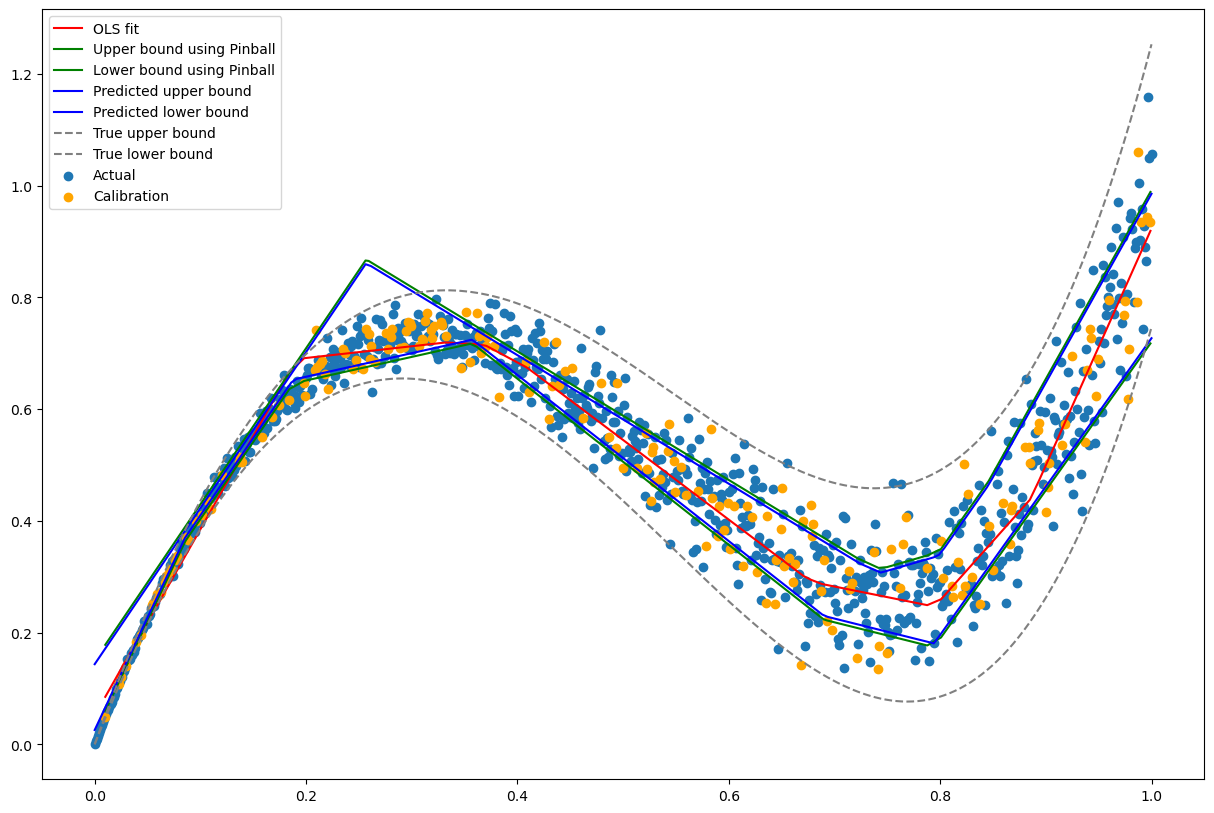

In [37]:
plt.figure(figsize=(15, 10))
plt.plot(sorted_X_cal, sorted_y_pred, color='red', label='OLS fit')

plt.plot(sorted_X_cal, sorted_upper,
         color='green', label='Upper bound using Pinball')
plt.plot(sorted_X_cal, sorted_lower,
         color='green', label='Lower bound using Pinball')
plt.plot(sorted_x_test, sorted_pred_upper,
         color='blue', label='Predicted upper bound')
plt.plot(sorted_x_test, sorted_pred_lower,
         color='blue', label='Predicted lower bound')
plt.plot(sorted_X_test, sorted_true_upper, color="gray", ls="--", label='True upper bound')
plt.plot(sorted_X_test, sorted_true_lower, color="gray", ls="--", label='True lower bound')
plt.scatter(X_train, y_train, color='tab:blue', label='Actual')
plt.scatter(X_cal, y_cal, color='orange', label='Calibration')
plt.legend()
plt.show()